(binimial-reg-notebook)=
# Regressione binomiale

Questo capitolo è dedicato alla regressione binomiale, un tipo specifico di analisi che utilizzata quando si hanno molteplici proporzioni di successi su $n$ prove.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
from scipy.special import expit

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")
az.style.use("arviz-viridish")

## Regressione binomiale

Nella regressione binomiale, da un insieme di frequenze del tipo "3 successi su 7 tentativi". Il modello della regressione binomiale è dato da:

$$
y_i \sim \text{Binomiale}(n, p_i)
$$

In questa equazione, $y_i$ rappresenta il numero di successi, $n$ è il numero totale di tentativi, e $p_i$ è la probabilità di successo. L'obiettivo è trovare un metodo per stimare $p_i$ utilizzando le variabili indipendenti a disposizione. Questo può essere espresso matematicamente come:

$$
p_i = \text{InverseLogit}(\beta_0 + \beta_1 \cdot x_i)
$$

Qui, $\beta_0$ e $\beta_1$ sono parametri che dobbiamo stimare. $x_i$ è la variabile predittiva e InverseLogit è una funzione che garantisce che la probabilità stimata $p_i$ sia compresa tra 0 e 1.

Per completare la Regressione Binomiale in un contesto Bayesiano, è poi necessario aggiungere le credenze priori riguardo ai parametri $\beta$, e utilizzare i dati osservati per il fitting del modello.

## Un esempio concreto

Seguiamo il tutorial di PyMC e generiamo dei dati sintetici.

In [4]:
# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})
data.head()

,x,y
0,-10.000000,1
1,-8.965517,1
2,-7.931034,3
3,-6.896552,3
4,-5.862069,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


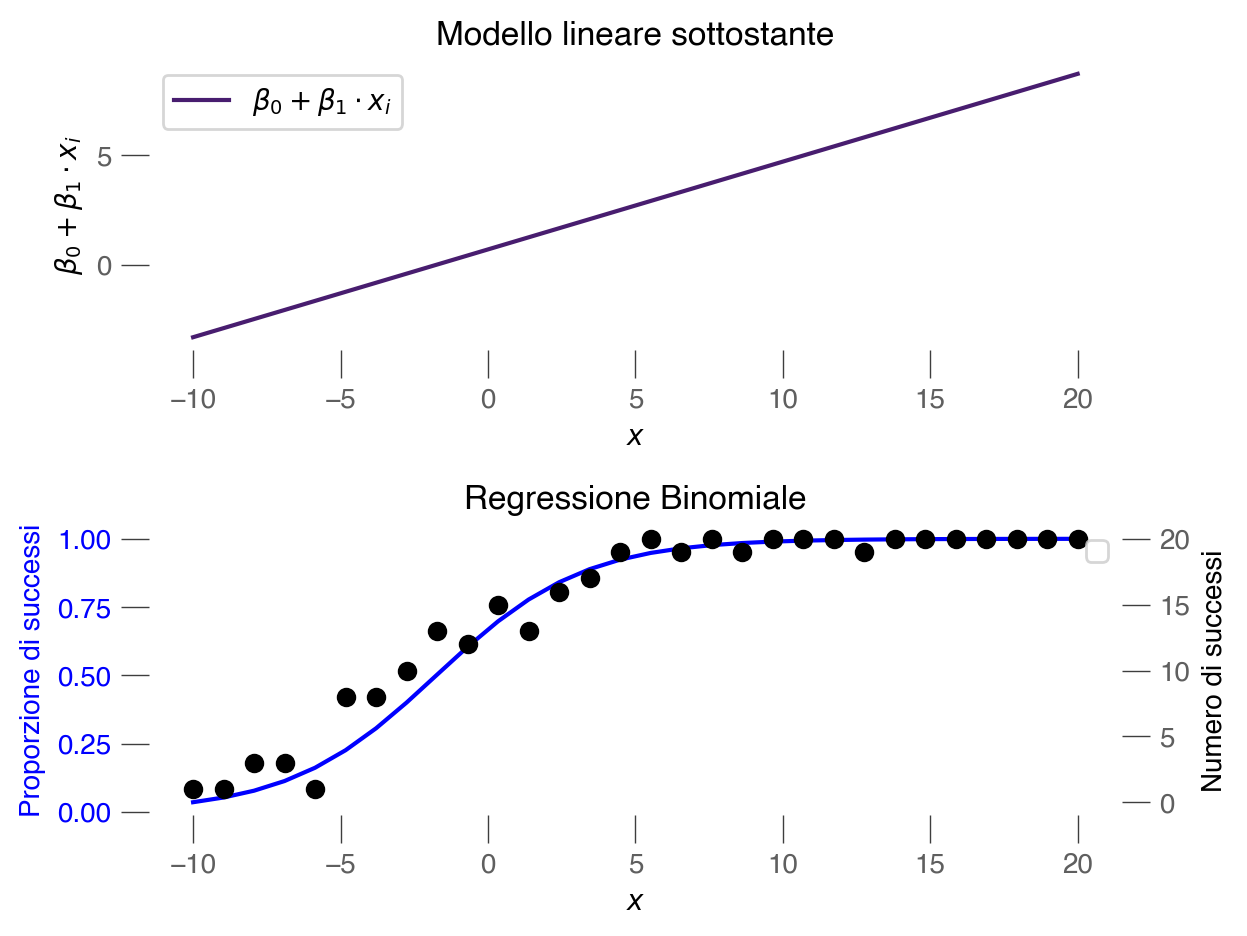

In [5]:
# Grafico del modello lineare sottostante
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(x, mu_true, label=r"$\beta_0 + \beta_1 \cdot x_i$")
plt.xlabel("$x$")
plt.ylabel(r"$\beta_0 + \beta_1 \cdot x_i$")
plt.title("Modello lineare sottostante")
plt.legend()

# Grafico della Regressione Binomiale
plt.subplot(2, 1, 2)
plt.plot(x, p_true, label=r"$g^{-1}(\beta_0 + \beta_1 \cdot x_i)$", color="b")
plt.ylabel("Proporzione di successi", color="b")
plt.tick_params(axis="y", labelcolor="b")
plt.xlabel("$x$")
plt.title("Regressione Binomiale")

# get y-axes to line up
y_buffer = 1

# Secondo asse y per il numero di successi
plt2 = plt.twinx()
plt2.scatter(x, y, color="k")
plt2.set_ylabel("Numero di successi")
plt2.set_ylim([-y_buffer, n + y_buffer])

plt.legend()
plt.tight_layout()
plt.show()

Il pannello superiore mostra il modello lineare nella sua forma non trasformata. Come si può osservare, questo modello lineare genera valori che escono dall'intervallo [0, 1], sottolineando quindi la necessità di una funzione di collegamento inversa. Questa funzione ha il compito di mappare i valori dal dominio dei numeri reali all'intervallo [0, 1]. Come abbiamo visto, questa trasformazione è realizzata mediante la funzione logistica inversa, anche conosciuta come funzione sigmoide logistica.

## PyMC

Scriviamo il modello in PyMC.

In [6]:
coords = {"observation": data.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.ConstantData("x", data["x"], dims="observation")
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")

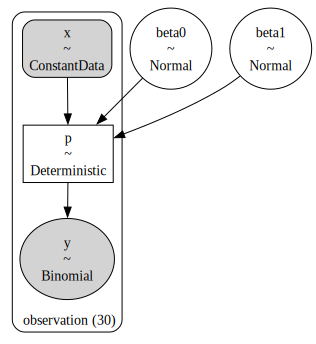

In [7]:
pm.model_to_graphviz(binomial_regression_model)

Eseguiamo il campionamento.

In [8]:
with binomial_regression_model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:02.596807
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 536.07it/s]


Sampling time =  0:00:04.178707
Transforming variables...
Transformation time =  0:00:00.112867
Computing Log Likelihood...
Log Likelihood time =  0:00:00.817139


Esaminiamo le distribuzioni a posteriori dei parametri.

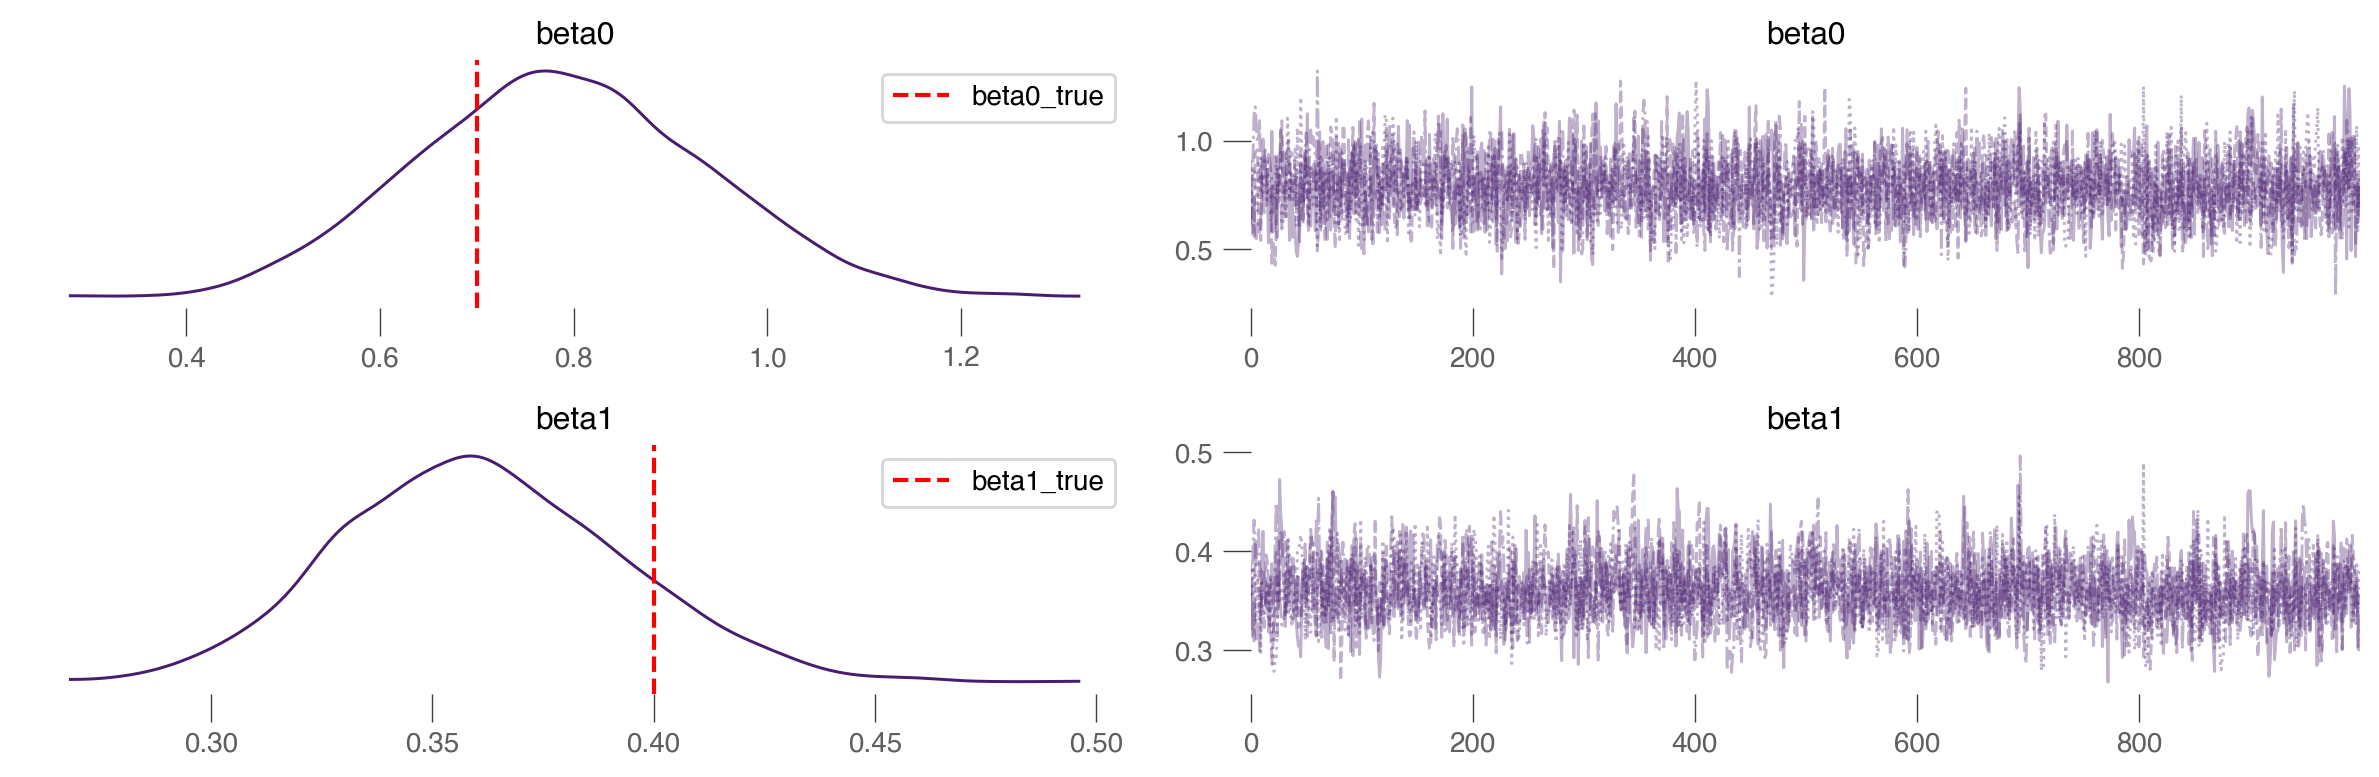

In [9]:
axes = az.plot_trace(idata, combined=True, var_names=["beta0", "beta1"])

# Aggiungi una linea verticale per beta0_true al pannello della densità del kernel per beta0
axes[0][0].axvline(beta0_true, color='r', linestyle='--', label='beta0_true')
axes[0][0].legend()

# Aggiungi una linea verticale per beta1_true al pannello della densità del kernel per beta1
axes[1][0].axvline(beta1_true, color='r', linestyle='--', label='beta1_true')
axes[1][0].legend()

plt.tight_layout()

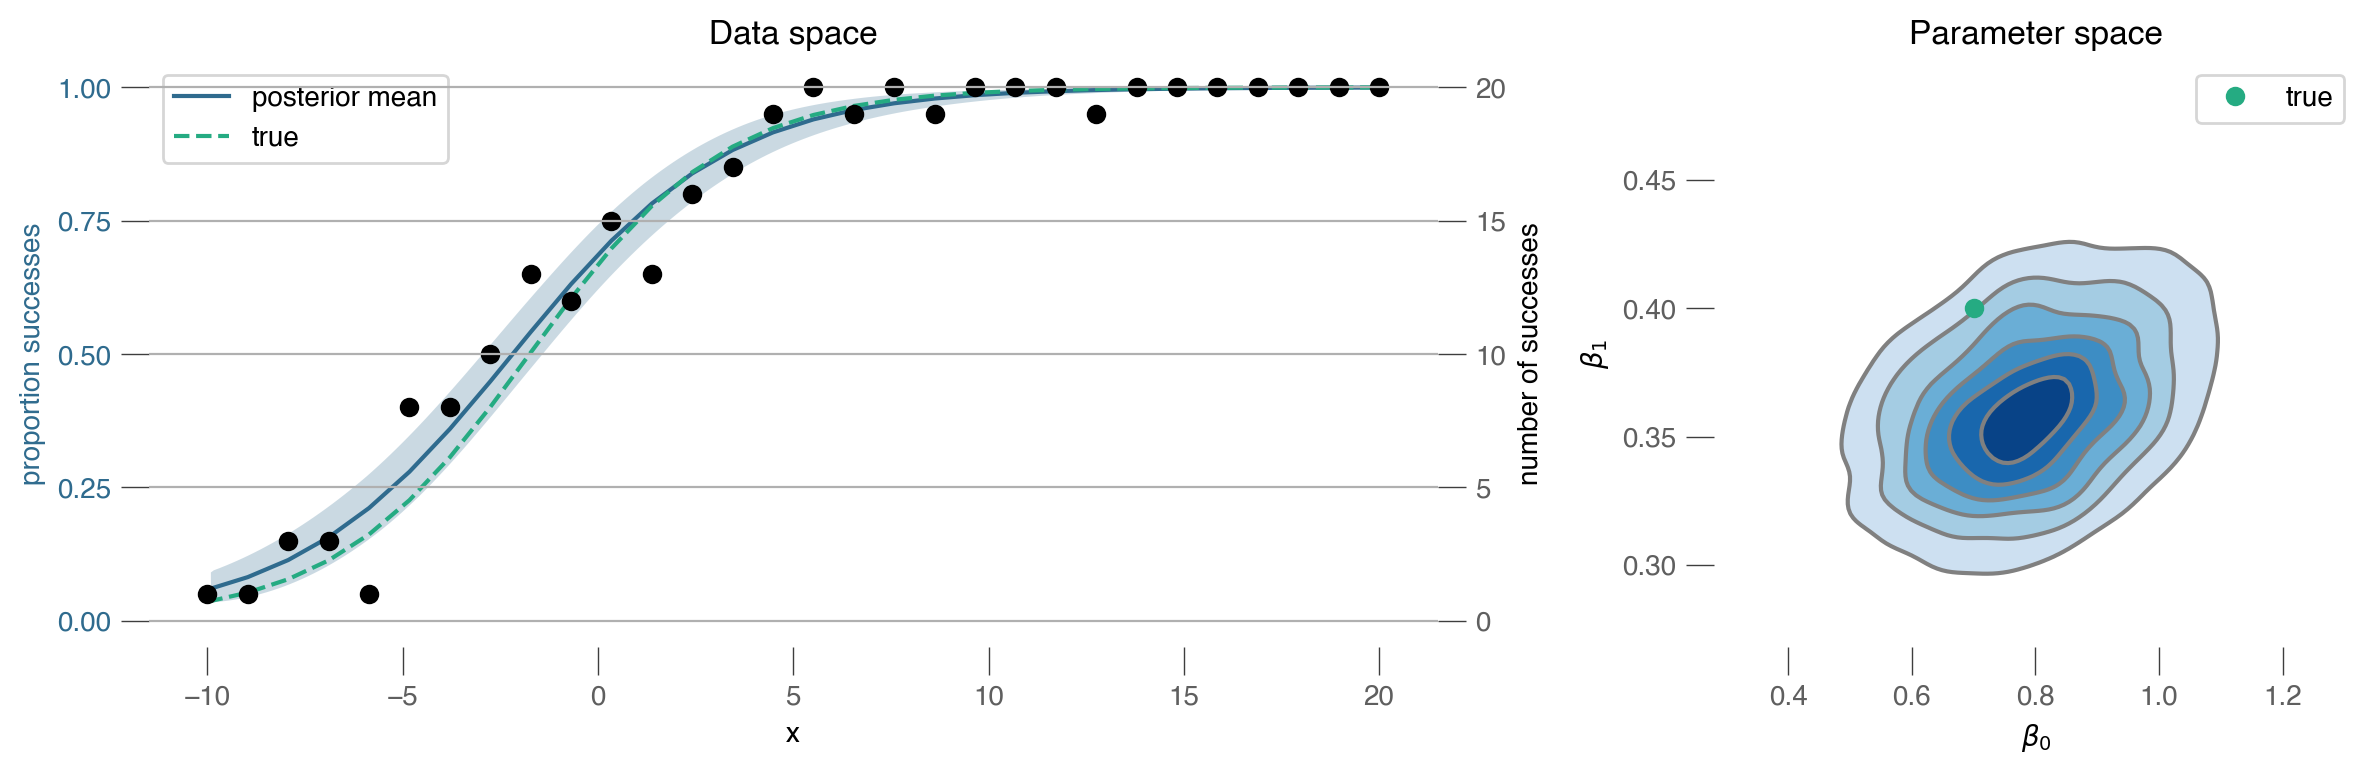

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True)
plt.tight_layout()

Il pannello di sinistra mostra la media posteriore (rappresentata dalla linea continua) e gli intervalli di credibilità al 95% (rappresentati dalla regione ombreggiata). Poiché stiamo lavorando con dati simulati, conosciamo il vero modello generativo dei dati. Pertanto, possiamo notare che la media posteriore si confronta favorevolmente con il modello vero e proprio che ha generato i dati.

Questo è confermato anche dalla distribuzione posteriore nello spazio dei parametri (pannello di destra), la quale si allinea bene con i parametri veri del modello generativo dei dati.

## Bambi

Ripetiamo l'analisi usando Bambi.

In [8]:
data["n"] = 20
data.head()

,x,y,n
0,-10.000000,1,20
1,-8.965517,1,20
2,-7.931034,3,20
3,-6.896552,3,20
4,-5.862069,1,20


In [9]:
formula = "p(y, n) ~ x"

In [10]:
model_logit = bmb.Model(formula, data, family="binomial")

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):


In [14]:
model_logit

       Formula: p(y, n) ~ x
        Family: binomial
          Link: p = logit
  Observations: 30
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.8634)
            x ~ Normal(mu: 0.0, sigma: 0.2792)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Eseguiamo il campionamento.

In [12]:
fitted = model_logit.fit(method="nuts_numpyro")

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(


Compiling...
Compilation time =  0:00:05.766163
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 567.27it/s]


Sampling time =  0:00:03.959877
Transforming variables...
Transformation time =  0:00:00.008510
Computing Log Likelihood...
Log Likelihood time =  0:00:00.918209


Esaminiamo i risultati.

In [13]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.785,0.145,0.519,1.060,0.003,0.002,2152.0,2720.0,1.0
x,0.354,0.029,0.296,0.407,0.001,0.001,1114.0,1405.0,1.0


I risultati replicano quelli trovati in precedenza.

## Watermark

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Aug 16 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.2
bambi     : 0.12.0
pandas    : 2.0.3
numpy     : 1.25.2
arviz     : 0.16.1

Watermark: 2.4.3

